# 0.0. Imports

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from tabulate              import tabulate


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
## define "Cramer V" as a function

def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min( kcorr-1, rcorr-1 )))


## define mean percentage error as a function

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)
     
## define mean absolute percentage error as a function    
    
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


## define MAE, MAPE and RMSE as a function

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


# define Cross Validation as a function

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv(r'..\datasets\rossmann_store_sales\train.csv',
                           low_memory=False)
df_store_raw = pd.read_csv(r'..\datasets\rossmann_store_sales\store.csv',
                           low_memory=False)

# merge datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. Data Description

## 1.1. Rename Columns

In [4]:
df_raw_1 = df_raw.copy()

In [5]:
df_raw_1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
# renaming columns to snakecase

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df_raw_1.columns = cols_new

df_raw_1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df_raw_1.shape[0]))
print('Number of Cols: {}'.format(df_raw_1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [8]:
df_raw_1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
# converting dates dtypes

df_raw_1['date'] = pd.to_datetime(df_raw_1['date'])

df_raw_1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df_raw_1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
# competition_distance - adding a value bigger than the max value from column
df_raw_1['competition_distance'] = df_raw_1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month - adding the sales month replacing NA
df_raw_1['competition_open_since_month'] = df_raw_1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year - adding the sales year replacing NA
df_raw_1['competition_open_since_year'] = df_raw_1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week - adding the sales week replacing NA
df_raw_1['promo2_since_week'] = df_raw_1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year - adding the sales year replacing NA
df_raw_1['promo2_since_year'] = df_raw_1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval - create a support col with month initials to apply in promo interval
month_map = {1: 'Jan', 
             2: 'Feb', 
             3: 'Mar', 
             4: 'Apr', 
             5: 'May', 
             6: 'Jun', 
             7: 'Jul', 
             8: 'Aug', 
             9: 'Sep', 
             10: 'Oct',  
             11: 'Nov', 
             12: 'Dec'}
df_raw_1['promo_interval'].fillna(0, inplace=True)
df_raw_1['month_map'] = df_raw_1['date'].dt.month.map(month_map)
                                               
df_raw_1['is_promo'] = df_raw_1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0., axis=1)

In [12]:
df_raw_1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [13]:
df_raw_1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                               float64
dtype: object

In [14]:
# converting new cols dtypes - float to int
df_raw_1['competition_open_since_month'] = df_raw_1['competition_open_since_month'].astype('int64')
df_raw_1['competition_open_since_year'] = df_raw_1['competition_open_since_year'].astype('int64')
df_raw_1['promo2_since_week'] = df_raw_1['promo2_since_week'].astype('int64')
df_raw_1['promo2_since_year'] = df_raw_1['promo2_since_year'].astype('int64')


In [15]:
df_raw_1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                               float64
dtype: object

## 1.7. Descriptive Statistical

In [16]:
# creating dataframe with numeric cols only
num_attributes = df_raw_1.select_dtypes(include=['int64', 'float64'])

# creating dataframe with categoric cols only
cat_attributes = df_raw_1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes


In [17]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


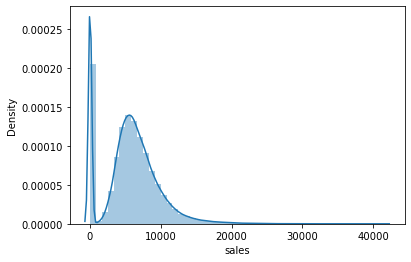

In [18]:
# plotting sales distribution
sns.distplot(df_raw_1['sales'])

C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


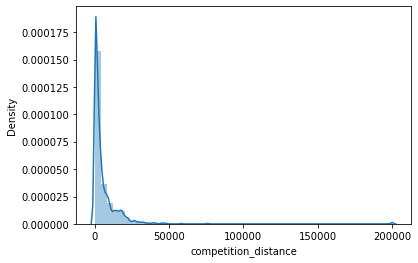

In [19]:
# plotting competition distance normal distribution
sns.distplot(df_raw_1['competition_distance'])

### 1.7.2. Categorical Attributes


In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

Dots above the maximum line are outliers - three times the standart deviation 


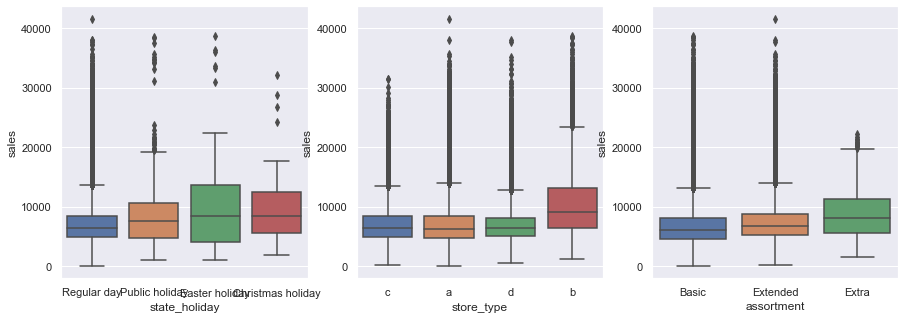

In [92]:
# filtering only state holidays with sales

aux_1 = df_raw_1[(df_raw_1['state_holiday'] != '0') & (df_raw_1['sales'] > 0)]

# using subplot to plot side by side

sns.set(rc={'figure.figsize':(15,5)})

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux_1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux_1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux_1)

print("Dots above the maximum line are outliers - three times the standart deviation ")

# 2.0. Feature Engineering

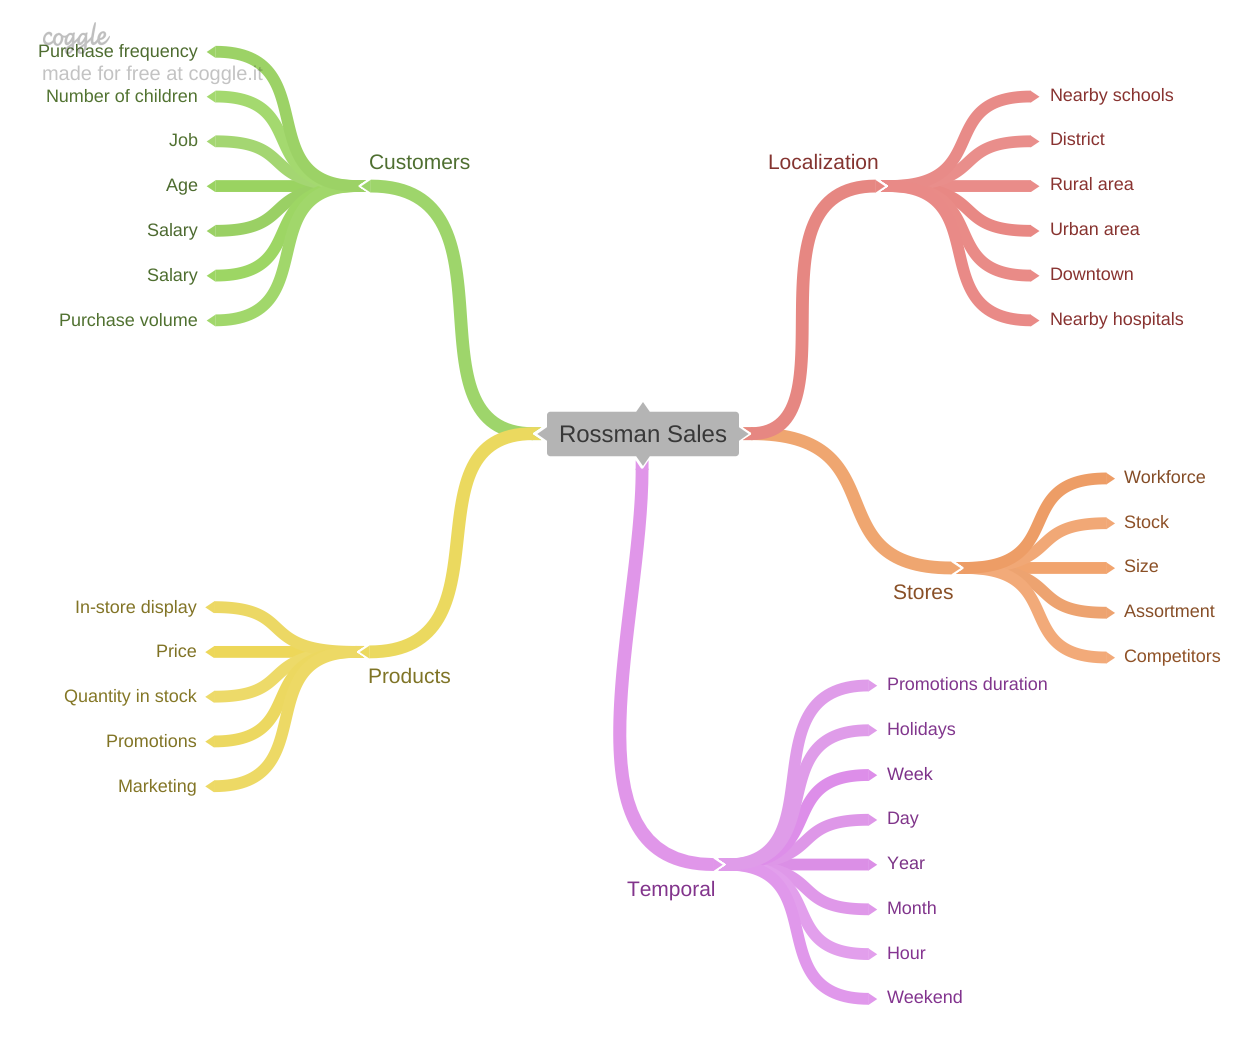

In [22]:
# dataframe copy
df2 = df_raw_1

# mind map hypothesis image
Image(r'..\images\mind_map_hypothesis.png')

## 2.1. Mind Map Hypoteses

### 2.1.1. Store Hypoteses

~**1.** Stores with a larger workforce should sell more;~

~**2.** Stores with greater stock capacity should sell more;~

~**3.** Larger stores should sell more;~

**4.** Stores with a larger assortment should sell more;

**5.** Stores with closer competitors should sell less;

**6.** Stores with longer competitors should sell more.

### 2.1.2. Product Hypoteses

~**1.** Stores that invest more in Marketing should sell more;~

~**2.** Stores with greater product exposure should sell more;~

~**3.** Stores with lower priced products should sell more;~

~**4.** Stores with more aggressive promotions should sell more;~

**5.** Stores with active promotions for longer should sell more;

**6.** Stores with more days of promotions should sell more;

**7.** Stores with more consecutive promotions should sell more.

### 2.1.2. Time Hypoteses

**1.** Stores open during the Christmas holiday should sell more;

**2.** Stores should sell more over the years;

**3.** Stores should sell more in the second half of the year;

**4.** Stores should sell more after the 10th of each month;

**5.** Stores should sell less on weekends;

**6.** Stores should sell less during school holidays.

## 2.2. Final Hypotesis List

*Discarding hypotheses based on the data available for analysis

**1.** Stores with a larger assortment should sell more;

**2.** Stores with closer competitors should sell less;

**3.** Stores with longer competitors should sell more;

**4.** Stores with active promotions for longer should sell more;

**5.** Stores with more days of promotions should sell more;

**6.** Stores with more consecutive promotions should sell more;

**7.** Stores open during the Christmas holiday should sell more;

**8.** Stores should sell more over the years;

**9.** Stores should sell more in the second half of the year;

**10.** Stores should sell more after the 10th of each month;

**11.** Stores should sell less on weekends;

**12.** Stores should sell less during school holidays.

## 2.3. Feature Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
## merge competition_open_since_month and competition_open_since_year
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1), axis=1)

## create competition since in time months feature
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
## concat promo2_since_year and promo2_since_week
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

## create promo_since as a date feature
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w')-datetime.timedelta(days=7))

## create promo_since_week feature
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'Basic' if x == 'a' else 
                                                      'Extra' if x == 'b' else 
                                                      'Extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'Public holiday' if x == 'a' else 
                                                            'Easter holiday' if x == 'b' else 
                                                            'Christmas holiday' if x == 'c' else
                                                            'Regular day')

In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,Regular day,Regular day,Regular day,Regular day,Regular day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Feature Filtering

In [25]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [26]:
# filtering only opened stores and stores with sales

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtering Columns

In [27]:
# drop "customers" and other derived columns

cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. Exploratory Data Analysis

In [28]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


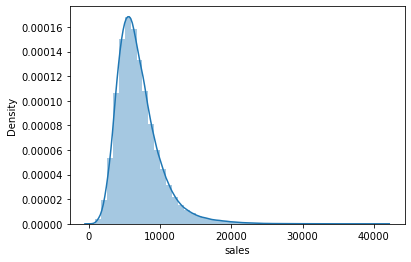

In [29]:
sns.distplot(df4['sales']);

C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


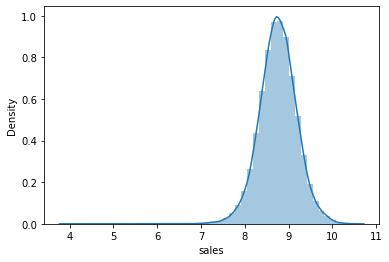

In [30]:
# approximating the response variable into a normally distributed variable

sns.distplot(np.log1p(df4['sales']));

### 4.1.2. Numerical Variables

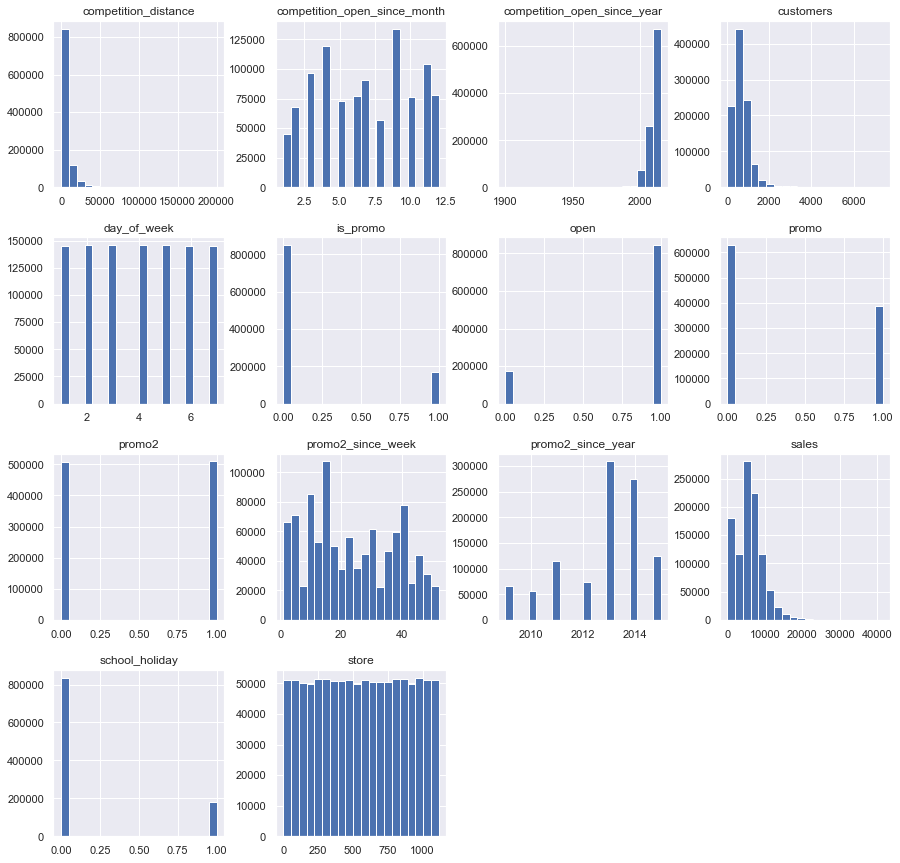

In [31]:
sns.set(rc={'figure.figsize':(15,15)})
num_attributes.hist(bins=20);

### 4.1.3. Categorical Variables

C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


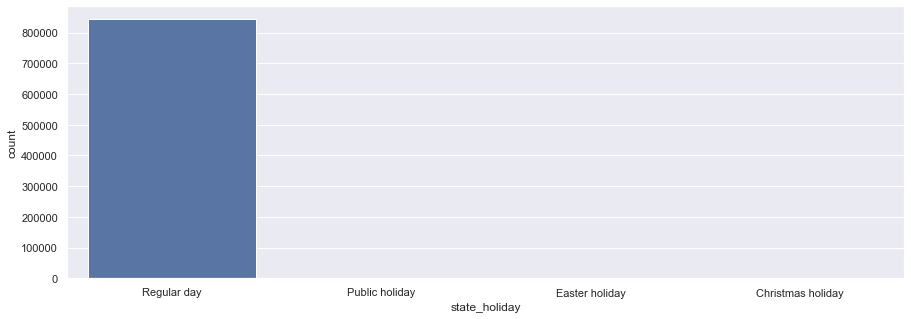

In [32]:
# state holiday

sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(df4['state_holiday']);

C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


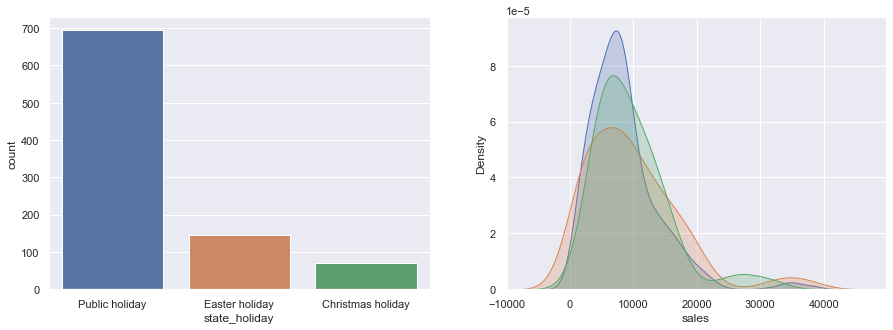

In [33]:
# state holiday without regular days
df4_aux1 = df4[df4['state_holiday'] != 'Regular day']

plt.subplot(1,2,1)
sns.countplot(df4_aux1['state_holiday']);

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['state_holiday']=='Public holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday']=='Easter holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday']=='Christmas holiday']['sales'],label='christmas_holiday',shade=True)

C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


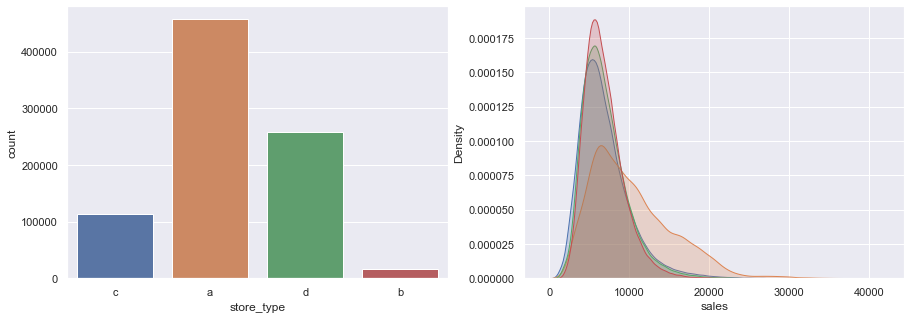

In [34]:
# store type
plt.subplot(1,2,1)
sns.countplot(df4['store_type']);

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a',shade=True)
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b',shade=True)
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c',shade=True)
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d',shade=True)

C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


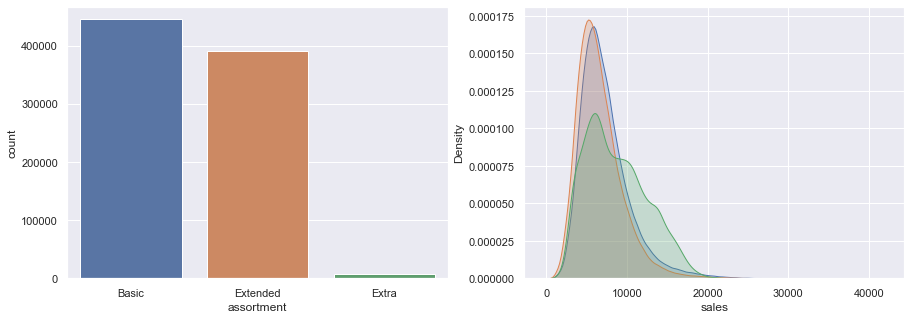

In [35]:
# assortment
plt.subplot(1,2,1)
sns.countplot(df4['assortment']);

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['assortment']=='Extended']['sales'],label='extended',shade=True)
sns.kdeplot(df4[df4['assortment']=='Basic']['sales'],label='basic',shade=True)
sns.kdeplot(df4[df4['assortment']=='Extra']['sales'],label='extra',shade=True)

## 4.2. Bivariated Analysis

### H1. Stores with a larger assortment should sell more

**TRUE**

Analyzing 'Extra' assortment behavior in third tile


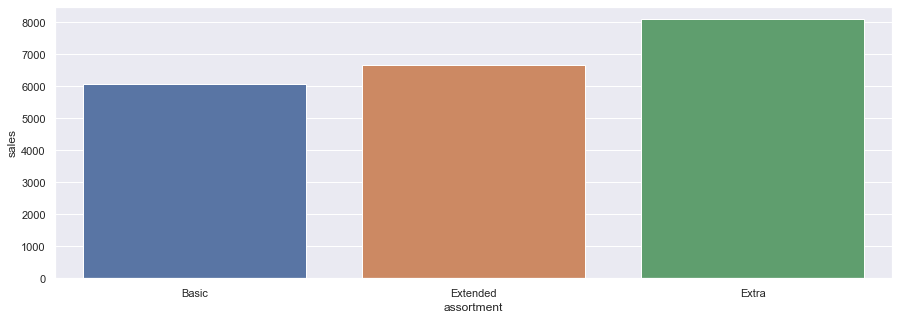

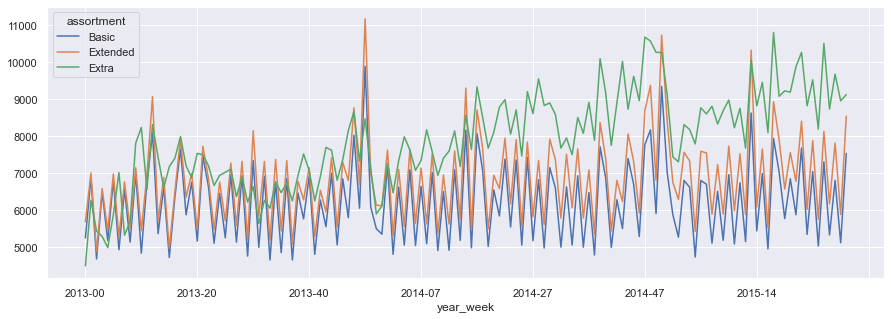

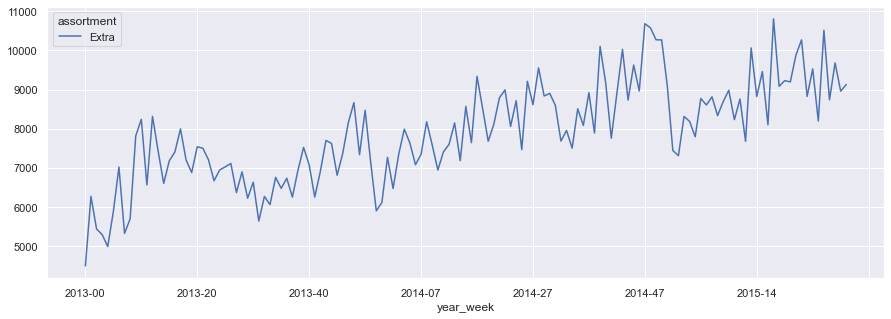

In [95]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').median().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).median().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales' ).plot()


print("Analyzing 'Extra' assortment behavior in third tile") 
aux3 = aux2[aux2['assortment'] == 'Extra']
aux3.pivot(index='year_week', columns='assortment', values='sales' ).plot()

### H2. Stores with closer competitors should sell less

**FALSE**

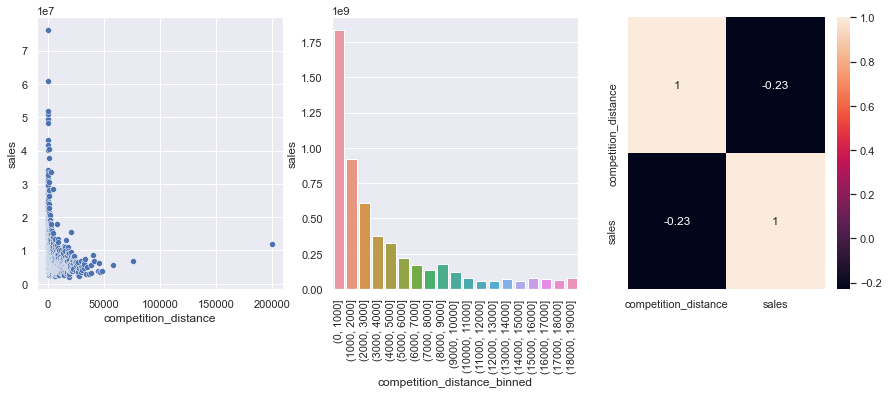

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot(1,3,2)
bins = list( np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot(1,3,3)
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H3. Stores with longer competitors should sell more

**FALSE**

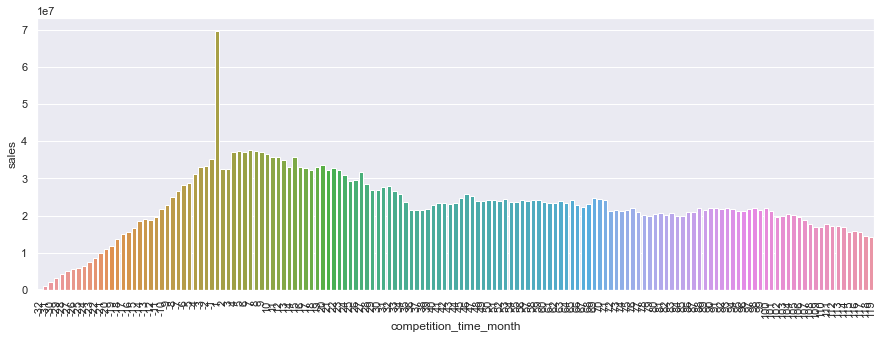

In [38]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks(rotation=90);

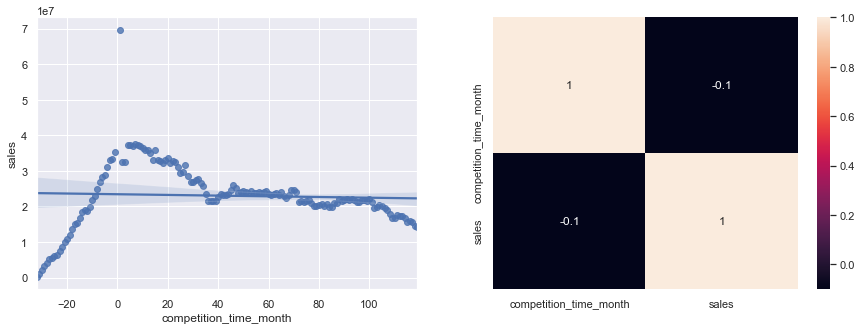

In [39]:
plt.subplot(1,2,1)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,2,2)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Stores with active promotions for longer should sell more
**FALSE**

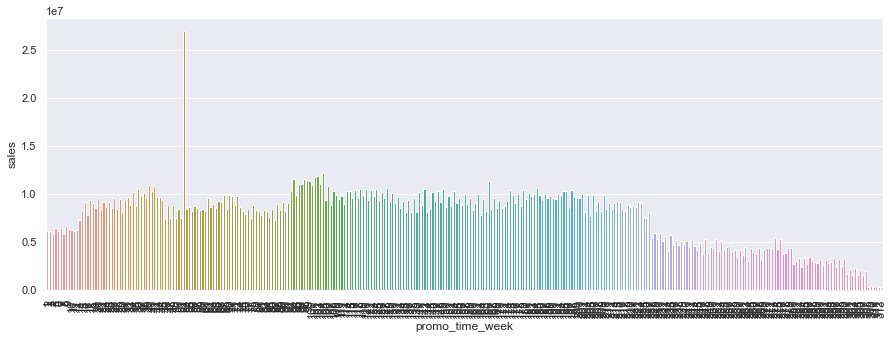

In [109]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks(rotation=90);

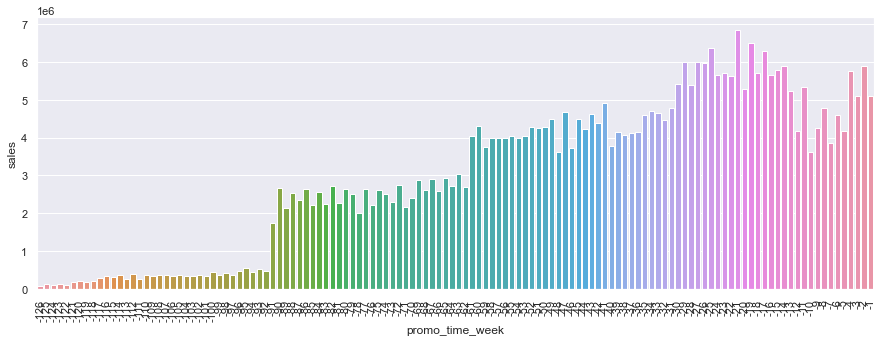

In [108]:
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular

sns.barplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

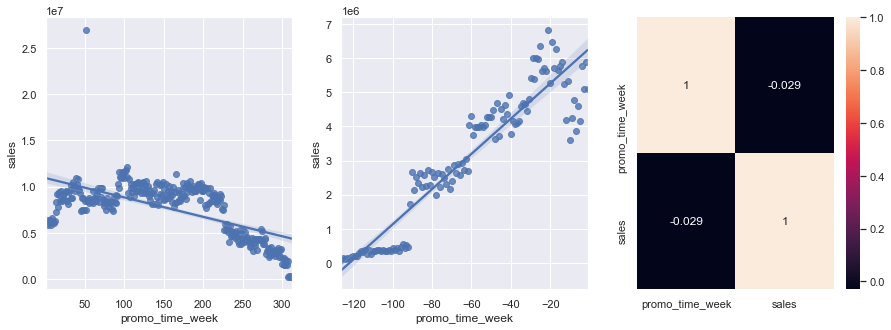

In [104]:
plt.subplot(1,3,1)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(1,3,2)
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H7. Stores with more days of promotions should sell more
**FALSE**

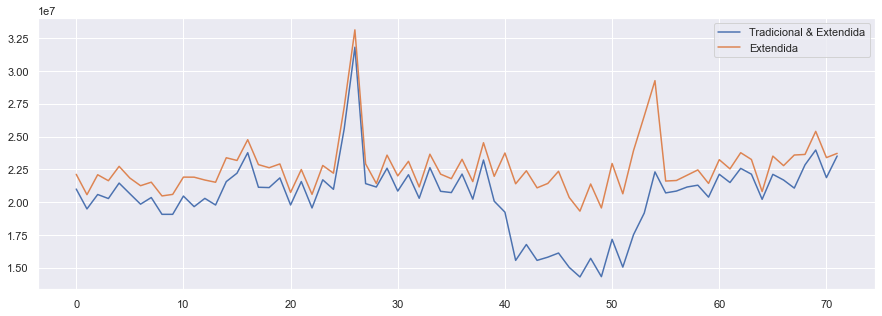

In [40]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H8. Stores open during the Christmas holiday should sell more
**FALSE**

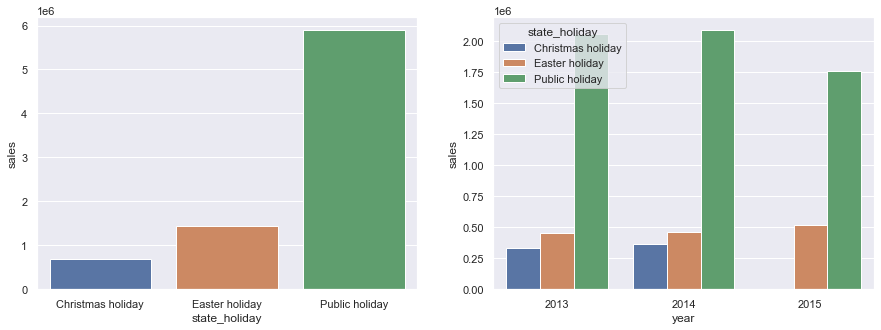

In [41]:
aux = df4[df4['state_holiday'] != 'Regular day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H9. Stores should sell more over the years
**FALSE**

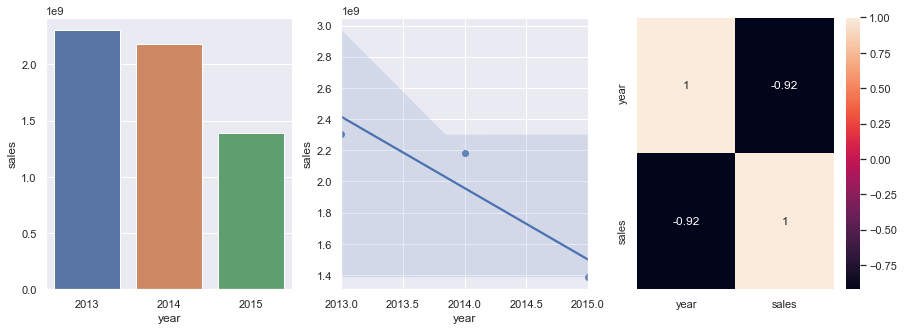

In [42]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Stores should sell more in the second half of the year
**FALSE**

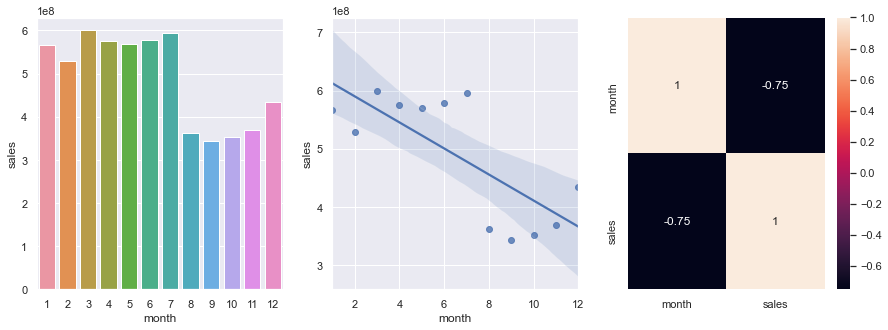

In [43]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H11. Stores should sell more after the 10th of each month
**TRUE**

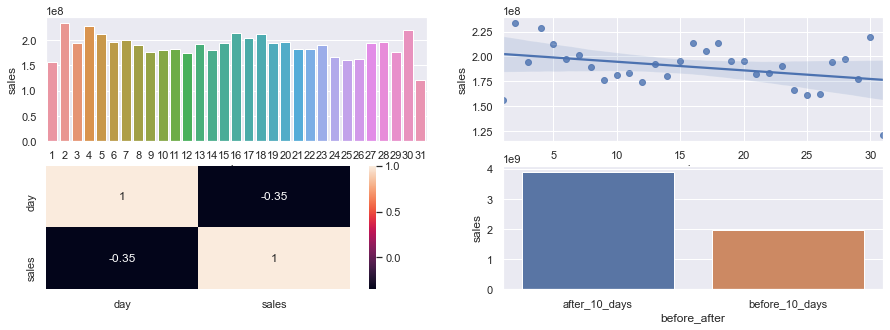

In [44]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);

### H12. Stores should sell less on weekends
**TRUE**

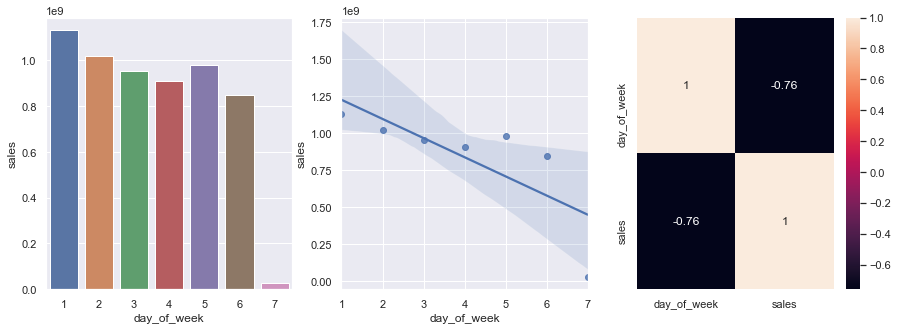

In [45]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H13. Stores should sell less during school holidays
**TRUE**

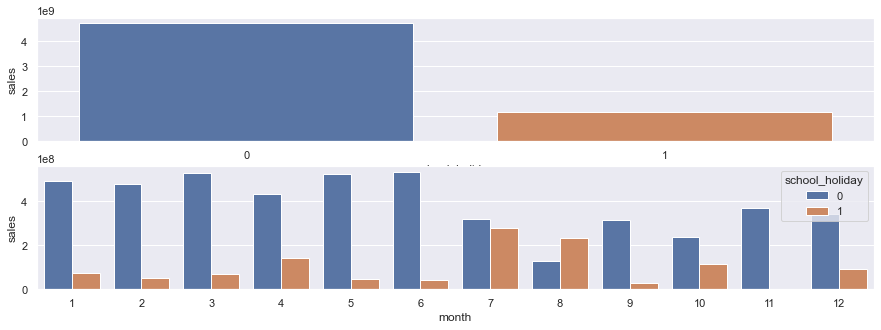

In [46]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Hypoteses Summary

In [47]:
tab =[['hypothesis', 'Conclusion', 'Relevance'],
      ['H1', 'True', 'High'],  
      ['H2', 'False', 'Low'],  
      ['H3', 'False', 'Low'],
      ['H4', 'False', 'Low'],
      ['H7', 'False', 'Low'],
      ['H8', 'False', 'Medium'],
      ['H9', 'False', 'High'],
      ['H10', 'False', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'High'],
      ['H13', 'True', 'Low'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            True          High
H2            False         Low
H3            False         Low
H4            False         Low
H7            False         Low
H8            False         Medium
H9            False         High
H10           False         High
H11           True          High
H12           True          High
H13           True          Low


### 4.3.1. Numerical Attributes

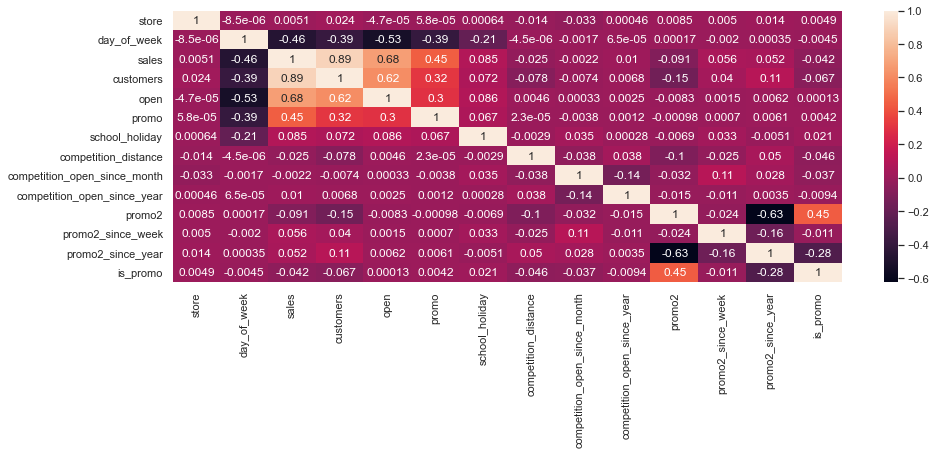

In [48]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

In [49]:
## only categorical data
#a = df4.select_dtypes(include='object')
#
## Calculate cramer V
#a1 = cramer_v(a['state_holiday'], a['state_holiday'])
#a2 = cramer_v(a['state_holiday'], a['store_type'])
#a3 = cramer_v(a['state_holiday'], a['assortment'])
#
#a4 = cramer_v(a['store_type'], a['state_holiday'])
#a5 = cramer_v(a['store_type'], a['store_type'])
#a6 = cramer_v(a['store_type'], a['assortment'])
#
#a7 = cramer_v(a['assortment'], a['state_holiday'])
#a8 = cramer_v(a['assortment'], a['store_type'])
#a9 = cramer_v(a['assortment'], a['assortment'])
#
## Final dataset
#d = pd.DataFrame({'state_holiday': [a1, a2, a3], 
#                  'store_type': [a4, a5, a6],
#                  'assortment': [a7, a8, a9]  })
#d = d.set_index(d.columns)
#
#sns.heatmap(d,annot=True)

# 5.0. Data Preparation

In [50]:
df5 = df4.copy()

## 5.1. Normalization

## 5.2. Rescaling

C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


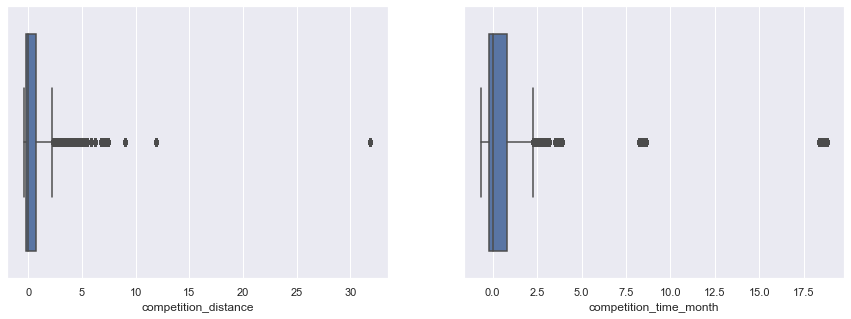

In [115]:
# outliers validation

plt.subplot(1,2,1)
sns.boxplot(df5['competition_distance']);

plt.subplot(1,2,2)
sns.boxplot(df5['competition_time_month'])

In [51]:
rs = RobustScaler()  # used in features with many outliers
mms = MinMaxScaler() # used in features with few outliers

## Robust Scaler technique

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

## MinMax Scaler technique

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Transformation

### 5.3.1. Encoding

In [52]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [53]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'Basic': 1,  'Extra': 2, 'Extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [54]:
# approximating the response variable to a normal distribution
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [55]:
# features with cyclical nature

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0. Feature Selection

In [56]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test datasets

In [57]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [58]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19'] 
y_train = X_train['sales']

# test dataset - using last 6 weeks
X_test = df6[df6['date'] >= '2015-06-19'] 
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [59]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [60]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [61]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0. Machine Learning Modelling

In [62]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. XGBoost Regressor

In [63]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[19:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.6064,0.949503,7330.742181


## 7.2. Cross Validation

In [64]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5
[19:29:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 4
[19:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[19:30:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  T

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.97 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


# 8.0. Hyperparameter Fine Tuning

## 8.1. Random Search

In [65]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [66]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
# model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

# performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
        
final_result

{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number: 5
[19:35:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 4
[19:42:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[19:49:32] WARNING: C:/Users/Administrato


KFold Number: 1
[00:02:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5
[00:11:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 4
[00:25:11] WARNING: C:/Users/Administrato

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1033.0 +/- 115.41,0.14 +/- 0.01,1484.06 +/- 149.41
0,XGBoost Regressor,818.06 +/- 125.64,0.11 +/- 0.01,1176.54 +/- 180.45
0,XGBoost Regressor,795.57 +/- 122.67,0.11 +/- 0.01,1149.42 +/- 182.05
0,XGBoost Regressor,1064.68 +/- 116.91,0.15 +/- 0.01,1533.46 +/- 149.95
0,XGBoost Regressor,861.61 +/- 149.41,0.12 +/- 0.02,1241.18 +/- 209.39


## 8.2. Final Model

In [67]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [68]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

[01:32:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.056876,0.114527,1088.444637


### 8.2.1. Final Model Cross Validation

In [69]:
xgb_result_tunned_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb_tuned, verbose=True )
xgb_result_tunned_cv


KFold Number: 5
[01:48:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 4
[02:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[02:12:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee" } might not be used.

  T

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,944.44 +/- 127.63,0.13 +/- 0.01,1340.76 +/- 172.96


In [70]:
# checking model bias
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.019542777303957218

# 9.0. Model Results

In [72]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

<ipython-input-72-14002072d9da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
<ipython-input-72-14002072d9da>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1. Business Results 

In [73]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [120]:
df92.sort_values('MAPE', ascending=False)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106846.78125,103486.930253,110206.632247,3359.850997,0.588673
908,909,228641.00000,220905.138587,236376.861413,7735.861413,0.515674
169,170,207572.87500,206069.607937,209076.142063,1503.267063,0.372436
875,876,202657.40625,198713.378949,206601.433551,3944.027301,0.317065
594,595,370525.71875,366236.873654,374814.563846,4288.845096,0.295612
...,...,...,...,...,...,...
322,323,276685.75000,276232.330131,277139.169869,453.419869,0.058861
1058,1059,321396.37500,320907.667217,321885.082783,488.707783,0.056900
741,742,302134.75000,301677.926388,302591.573612,456.823612,0.056084
1088,1089,373012.71875,372446.136494,373579.301006,566.582256,0.053381


In [122]:
# exporting predictions per store
df92.sort_values('MAPE', ascending=False).to_csv(r'..\datasets\train\predictions_per_store.csv')

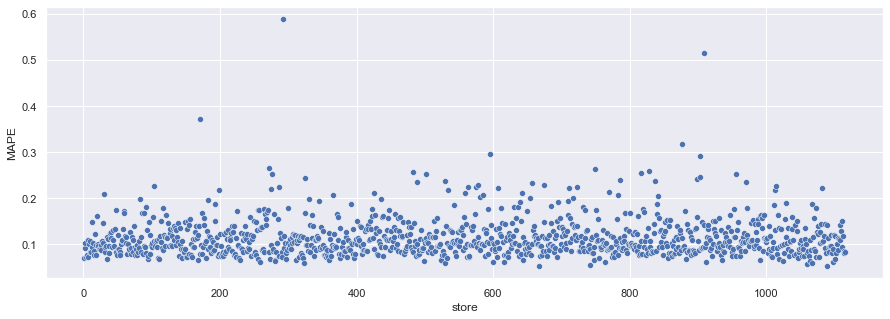

In [75]:
# MAPE per Store dispersion
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [76]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$287,260,406.53"
1,worst_scenario,"R$286,409,667.53"
2,best_scenario,"R$288,111,145.53"


## 9.3. Machine Learning Performance

In [77]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<ipython-input-77-0c99df7e7a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
<ipython-input-77-0c99df7e7a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


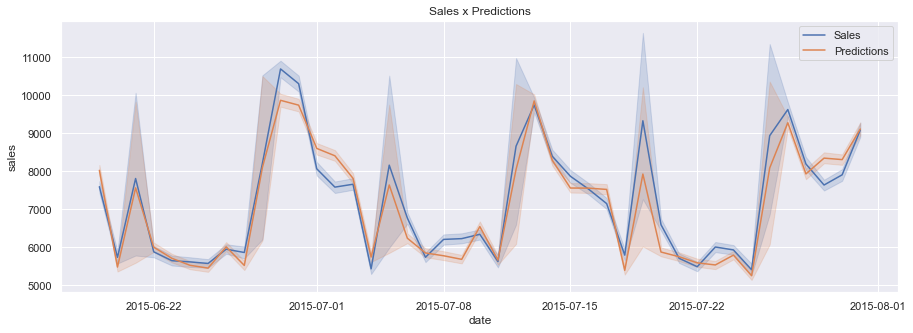

In [83]:
# sales predictions for the next 6 weeks

sns.lineplot( x='date', y='sales', data=df9, label='Sales' );
sns.lineplot( x='date', y='predictions', data=df9, label='Predictions' );
plt.title('Sales x Predictions');

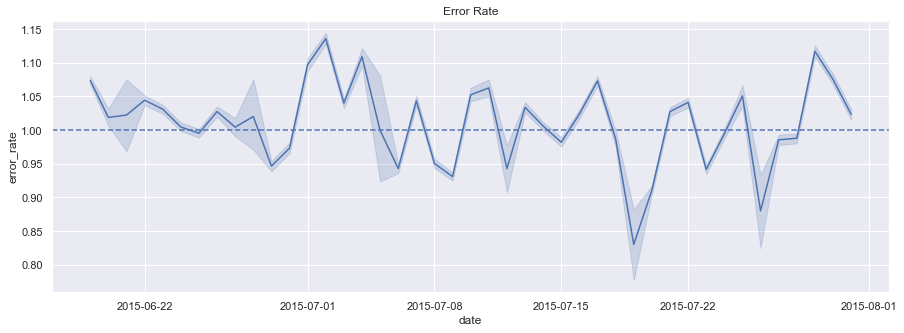

In [84]:
# sales error rate for the next 6 weeks

sns.lineplot( x='date', y='error_rate', data=df9 );
plt.axhline( 1, linestyle='--');
plt.title('Error Rate');

C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


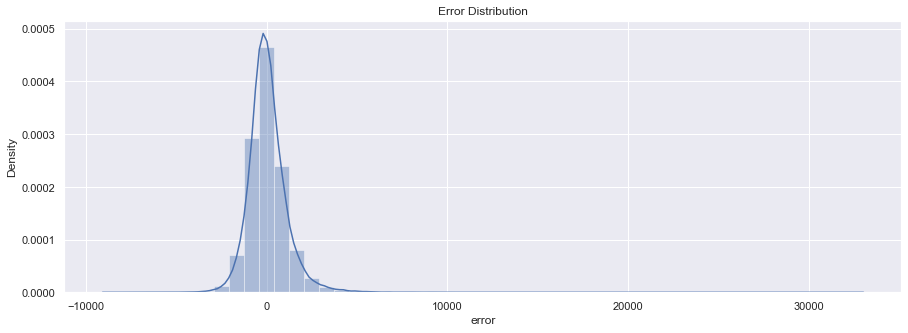

In [85]:
# error density

sns.distplot( df9['error'] );
plt.title('Error Distribution');

C:\Users\vitor.musachio\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


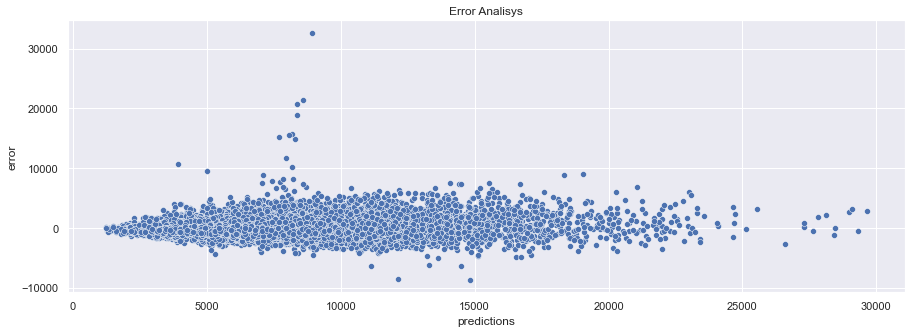

In [86]:


sns.scatterplot( df9['predictions'], df9['error'] );
plt.title('Error Analisys');